# Read Zebris pressure platform ASCII files

Marcos Duarte

The Zebris Medical GmbH (https://www.zebris.de/en/) builds devices for measuring pressure on the foot/platform interface.  
The BMClab (http://demotu.org/) has two zebris FDM 1.5 platforms for measuring pressure and each one has the following specs:  
 - Measuring principle: capacitive force measurement  
 - Dimensions: 158 x 60.5 x 2.1 cm (L x W x H)  
 - Sensor area: 149 x 54.2 cm (L x W)  
 - Number of sensors: 11264  
 - Physical resolution: 1.4 sensors /cm2  (0.714 cm2)
 - Sampling frequency: 100 Hz  
 - Measuring Range: 1 - 120 N/cm2  
 - Accuracy of the calibrated measuring range: (1 – 80 N/cm2), ±5% (FS)  
 - Hysteresis: < 3 % (FS)  
 
The two pressure platforms can be synchronized and used as a single 3-m platform.  

The proprietary software to operate the pressure device saves files in ASCII and binary formats with the pressure data. Here are functions for reading most of the files saved in ASCII format. These files have headers with metadata about the patient and acquisition conditions and the data of pressure, force, or center of pressure  depending on the type of acquisition and chosen option to export the data.

## APD file

The .apd file in ASCII contains the metadata and the maximum values of pressure during the trial only at the regions where there were pressure greater than the threshold (1 N/cm2). This file can be used for making insoles.  
Here is a typical .apd file:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(1, r'./../functions')

In [2]:
path2 = './../Data/'
filename = path2 + 'MDwalk2.apd'
with open(file=filename, mode='rt', newline='') as f:
    print(f.read())

[General]
Description=pedcad Importfile
Source=<<zebris>>
Date=25/04/2017
Time=18.23.47
UnitDistance=mm
UnitPressure=N/cm2

[Customer]
FirstName=M
LastName=D
Sex=M

[Technical]
MaxSensorsX=353
MaxSensorsY=64
StartSensX=233
StartSensY=8
SensCountX=32
SensCountY=15
LDistX=8.46591
LDistY=8.46591

[Data]
-1	-1	1.0	3.0	2.5	0.5	-1	-1	-1	-1	-1	-1	-1	-1	-1
-1	2.0	10.0	16.5	15.5	7.5	1.5	-1	-1	-1	-1	-1	-1	-1	-1
-1	7.0	21.0	26.0	25.0	20.0	5.5	0.5	-1	-1	-1	-1	-1	-1	-1
0.5	9.5	24.0	30.5	30.5	24.0	10.5	1.0	-1	-1	-1	-1	-1	-1	-1
0.5	9.0	23.5	29.0	29.0	28.5	18.0	3.5	-1	-1	-1	-1	-1	-1	-1
-1	6.0	22.5	28.0	28.0	27.5	21.5	5.5	-1	-1	-1	-1	-1	-1	-1
-1	3.5	16.0	25.5	26.5	25.5	22.0	7.5	0.5	-1	-1	-1	-1	-1	-1
-1	0.5	8.0	19.0	21.5	21.5	18.0	8.0	1.5	-1	-1	-1	-1	-1	-1
-1	-1	2.5	8.0	12.5	14.0	13.0	8.0	3.0	-1	-1	-1	-1	-1	-1
-1	-1	-1	1.5	5.0	7.5	9.0	8.0	4.5	-1	-1	-1	-1	-1	-1
-1	-1	-1	-1	1.0	4.0	6.5	7.5	6.5	2.5	-1	-1	-1	-1	-1
-1	-1	-1	-1	-1	1.5	4.5	7.5	9.0	5.5	1.0	-1	-1	-1	-1
-1	-1	-1	-1	-1	-1	3.0	7.5	11.0	9.5	4.0	-1	-

Here is a function for reading an .apd file from Zebris pressure platform:

In [3]:
def read_zebris_apd(filename):
    """Reads Zebris pressure platform ASCII files .apd.
    """
    
    import numpy as np
    import pprint
    
    sections = ['General', 'Customer', 'Technical', 'Data']
    s = 0
    info = {}
    with open(file=filename, mode='rt', newline='') as f:
        for linea in f:
            line = linea.strip('\r[]\n')
            if line == sections[s]:
                info[sections[s]] = {}
                s += 1
            elif line:
                info[sections[s-1]][line.split('=')[0]] = line.split('=')[1]
            elif s == 3:
                break
        f.readline()  #'Data'
        data = np.loadtxt(f, delimiter='\t')
        data[data == -1] = 0  #np.nan
        
        print('File %s successfully open.' %filename)
        #print('\nFile information:')
        #pprint.pprint(info)
        
        print('Data has %d rows and %d columns.' %(data.shape))
        
    return info, data

In [4]:
info, data = read_zebris_apd(filename)

File ./../Data/MDwalk2.apd successfully open.
Data has 32 rows and 15 columns.


### Simple 2D plot of the raw data

Shapes:
X: (32, 15) Y: (32, 15) data: (32, 15)


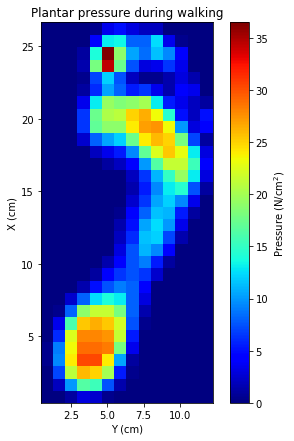

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Prepare data for plotting
dx = float(info['Technical']['LDistX'])/10
dy = float(info['Technical']['LDistY'])/10
x = np.arange(1/2, data.shape[0] + 1/2, 1)*dx
y = np.arange(1/2, data.shape[1] + 1/2, 1)*dy
X, Y = np.meshgrid(y, x)
print('Shapes:')
print('X:', X.shape, 'Y:', Y.shape, 'data:', data.shape)

fig, ax = plt.subplots(figsize=(6, 7))
img = ax.pcolormesh(X, Y, data, cmap=cm.jet)
ax.set_aspect('equal')
fig.colorbar(img, label='Pressure (N/cm$^2$)')
ax.set_xlabel('Y (cm)')
ax.set_ylabel('X (cm)')
ax.set_title('Plantar pressure during walking')
plt.show()

#### 2D plot with filtering

Let's use the matplotlib function [`imshow`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) for plotting raw and filtered data.  
For the difference between `imshow` and `pcolormesh`, see https://stackoverflow.com/questions/21166679/when-to-use-imshow-over-pcolormesh.

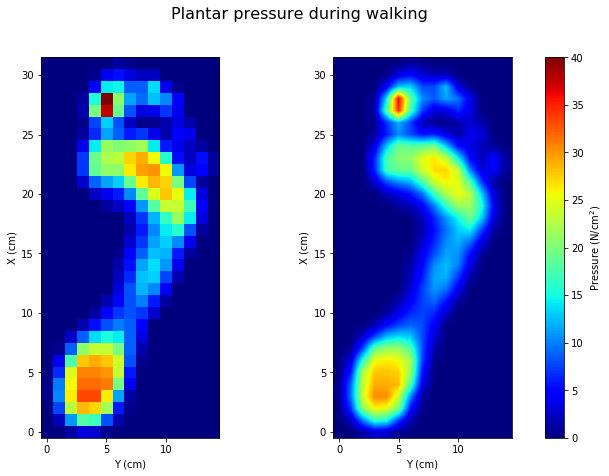

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
img0 = ax[0].imshow(data, cmap=cm.jet, aspect='equal', origin='lower', 
                interpolation='nearest')
ax[0].set_xlabel('Y (cm)')
ax[0].set_ylabel('X (cm)')
img1 = ax[1].imshow(data, cmap=cm.jet, aspect='equal', origin='lower', 
                interpolation='bilinear', vmin=0, vmax=40)
ax[1].set_xlabel('Y (cm)')
ax[1].set_ylabel('X (cm)')
fig.colorbar(img1, ax=list(ax), label='Pressure (N/cm$^2$)')
fig.suptitle('Plantar pressure during walking', fontsize=16)
plt.show()

#### 3D plots

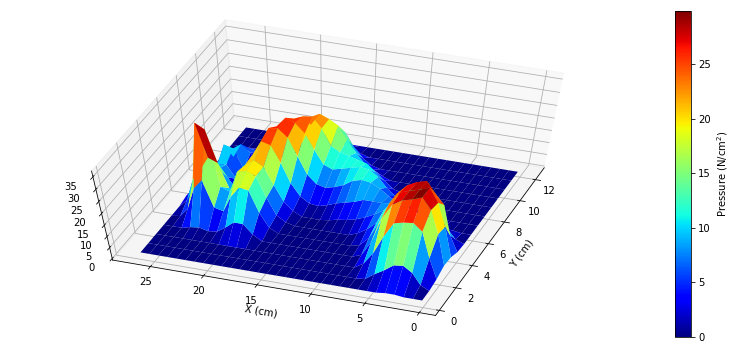

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, data, cmap=cm.jet,
                       rcount=data.shape[0], ccount=data.shape[1],
                       linewidth=0, antialiased=True)
ax.view_init(60, 200)
fig.colorbar(surf, orientation='vertical', label='Pressure (N/cm$^2$)')
ax.set_xlabel('Y (cm)')
ax.set_ylabel('X (cm)')
plt.show()

#### 3D plot with data filtering

In [8]:
from scipy import interpolate
# interpolate data over a four times denser grid
dxy = float(info['Technical']['LDistX'])/10  # the pressure cell is squared
x2 = np.arange(1/8, data.shape[0] + 1/8, 1/4)*dx
y2 = np.arange(1/8, data.shape[1] + 1/8, 1/4)*dx
X2, Y2 = np.meshgrid(y2, x2)
tck = interpolate.bisplrep(X, Y, data)
data2 = interpolate.bisplev(X2[0,:], Y2[:,0], tck).T
print('Shapes:')
print('X2:', X2.shape, 'Y2:', Y2.shape, 'data2:', data2.shape)

Shapes:
X2: (128, 60) Y2: (128, 60) data2: (128, 60)


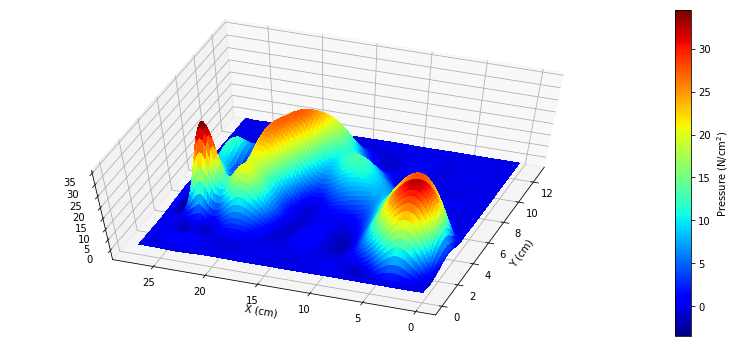

In [9]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X2, Y2, data2, cmap=cm.jet,
                       rcount=data2.shape[0], ccount=data2.shape[1],
                       linewidth=0, antialiased=False)
ax.view_init(60, 200)
fig.colorbar(surf, orientation='vertical', label='Pressure (N/cm$^2$)')
ax.set_xlabel('Y (cm)')
ax.set_ylabel('X (cm)')
plt.show()

### Loading several steps of a trial

In [10]:
def plot_apd(info, data, ax, title):
    
    dxy = float(info['Technical']['LDistX'])/10
    x0 = int(info['Technical']['StartSensY'])*dx
    y0 = int(info['Technical']['StartSensX'])*dy
    xlen = int(info['Technical']['SensCountY'])
    ylen = int(info['Technical']['SensCountX'])
    img = ax.imshow(data, cmap=cm.jet, aspect='auto', origin='lower', 
                    extent=[x0, x0+xlen*dx, y0, y0+ylen*dy],
                    interpolation='nearest', vmin=0, vmax=40) 
    ax.set_title(title)
    ax.set_xlabel('Y (cm)')
    
    return img

File ./../Data/MDwalk2.apd successfully open.
Data has 32 rows and 15 columns.
File ./../Data/MDwalk2_1.apd successfully open.
Data has 32 rows and 13 columns.
File ./../Data/MDwalk2_2.apd successfully open.
Data has 31 rows and 12 columns.
File ./../Data/MDwalk2_3.apd successfully open.
Data has 30 rows and 13 columns.
File ./../Data/MDwalk2_4.apd successfully open.
Data has 32 rows and 15 columns.


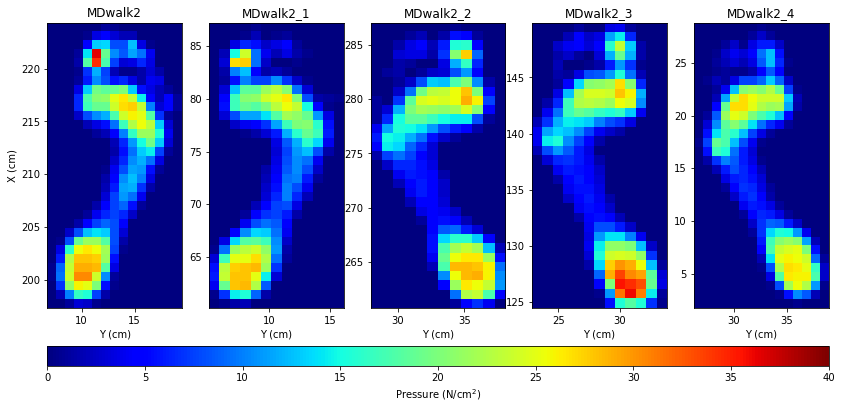

In [11]:
steps = ['MDwalk2' + step for step in ['', '_1', '_2', '_3', '_4']]
infos, datas = {}, {}
fig, axs = plt.subplots(1, len(steps), figsize=(14, 7))
for s, step in enumerate(steps):
    infos[step], datas[step] = read_zebris_apd(path2 + step + '.apd')
    img = plot_apd(infos[step], datas[step], axs[s], step)

#fig.suptitle('Plantar pressure during walking', fontsize=16)
axs[0].set_ylabel('X (cm)')
fig.colorbar(img, ax=list(axs), label='Pressure (N/cm$^2$)',
             orientation='horizontal', pad=.1, aspect=40)
plt.show()

It seems the Zebris software when exporting the pressure data to .apd files of a trial with a sequence of steps, saves first the data of the right foot and then of the left foot.  

The origin of the pressure platform was at the far right corner in relation to the walking direction of the subject in this trial (see the values at the x and y axes). So, the order of the subject's foot steps were: MDwalk2_4, MDwalk2_1, MDwalk2_3, MDwalk2, and MDwalk2_2.

The size of the pressure data across steps is not constant, the width varies from 12 to 15 columns and the length varies from 30 to 32 rows of data. Multiply these numbers by 0.846591 cm to have the size of the pressure data in centimeters. Possible reasons for this variation are: 1. foot rotation, 2. differences at how the foot is supported at the ground at each step, and 3. perhaps measurement noise. So, one can't directly compare the images (the pressures), for example, we can't average the data in order to get the mean foot pressure (or other statistics related to the positions of the steps); we will have first to align the data (each step) and account for the different sizes. In image processing, this procedure is part of what is known as [image registration](https://en.wikipedia.org/wiki/Image_registration). For the application of image registration to foot plantar pressure, see Pataky et al. (2008), Oliveira et al. (2010).

For now, given that there are only few steps and they seemed to be similar, we will only transform the images to have the same size.

### Image resize

MDwalk2 has 120 rows and 60 columns.
MDwalk2_1 has 120 rows and 60 columns.
MDwalk2_2 has 120 rows and 60 columns.
MDwalk2_3 has 120 rows and 60 columns.
MDwalk2_4 has 120 rows and 60 columns.


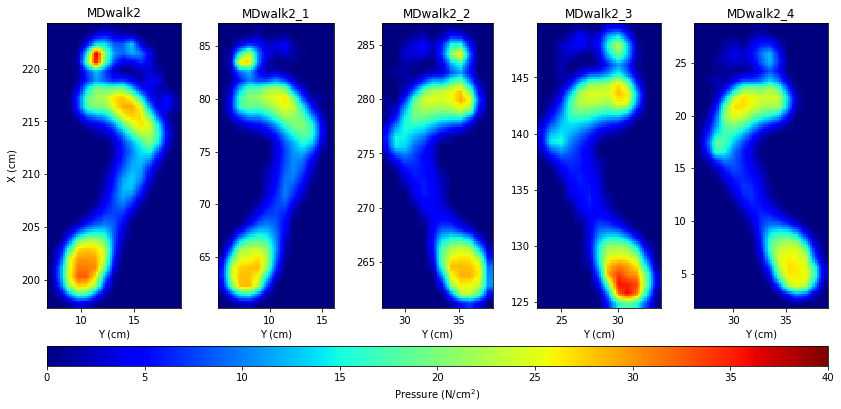

In [12]:
from scipy.misc import imresize

datas2 = {}
fig, axs = plt.subplots(1, len(steps), figsize=(14, 7))
for s, step in enumerate(steps):
    maxdata = datas[step].max()
    datas2[step] = imresize(datas[step], size=(120, 60), interp='bilinear')
    datas2[step] = maxdata*(datas2[step]/datas2[step].max())
    print('%s has %d rows and %d columns.' %(step, *datas2[step].shape))
    img = plot_apd(infos[step], datas2[step], axs[s], step)
    axs[s].set_aspect('equal')

#fig.suptitle('Plantar pressure during walking', fontsize=16)
axs[0].set_ylabel('X (cm)')
fig.colorbar(img, ax=list(axs), label='Pressure (N/cm$^2$)',
             orientation='horizontal', pad=.1, aspect=40)
plt.show()

We can now calculate for instance the left and right steps with the maxium pressure of all corresponding steps:

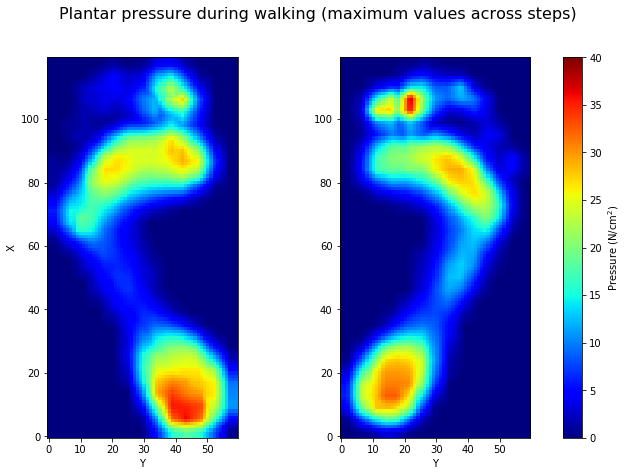

In [13]:
max_step_r = np.max(np.stack((datas2[steps[0]], datas2[steps[1]]), 2), 2)
max_step_l = np.max(np.stack((datas2[steps[2]], datas2[steps[3]], datas2[steps[4]]), 2), 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 7))
img0 = axs[0].imshow(max_step_l, cmap=cm.jet, aspect='equal', origin='lower', 
                interpolation='nearest', vmin=0, vmax=40)
axs[0].set_xlabel('Y')
axs[0].set_ylabel('X')
img1 = axs[1].imshow(max_step_r, cmap=cm.jet, aspect='equal', origin='lower', 
                interpolation='nearest', vmin=0, vmax=40)
axs[1].set_xlabel('Y')
fig.colorbar(img1, ax=list(axs), label='Pressure (N/cm$^2$)')
fig.suptitle('Plantar pressure during walking (maximum values across steps)', fontsize=16)
plt.show()

It doesn't work!  
We need to perform image registration...

## References

- [Pataky TC1, Goulermas JY, Crompton RH. (2008) A comparison of seven methods of within-subjects rigid-body pedobarographic image registration. J Biomech., 20;41(14):3085-9. doi: 10.1016/j.jbiomech.2008.08.001](https://www.ncbi.nlm.nih.gov/pubmed/18790481).  
- [Oliveira FP1, Pataky TC, Tavares JM (2010) Registration of pedobarographic image data in the frequency domain. Comput Methods Biomech Biomed Engin., 13(6):731-40. doi: 10.1080/10255840903573020](https://www.ncbi.nlm.nih.gov/pubmed/20526916). [PDF](http://paginas.fe.up.pt/~tavares/downloads/publications/artigos/CMBBE_13_6_2010.pdf)